In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import omegaconf

import mbrl.env.cartpole_continuous as cartpole_env
import mbrl.env.reward_fns as reward_fns
import mbrl.env.termination_fns as termination_fns
import mbrl.models as models
import mbrl.planning as planning
import mbrl.util as util

%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

# Creating the environment

In this example, we show how to use our toolbox to write the PETS algorithm (Chua at al., NeurIPS 2018), and use it to solve a continuous version of the cartpole environment. 

First we instantiate the environment and initialize some utility objects.

In [2]:
env = cartpole_env.CartPoleEnv()
rng = np.random.default_rng(seed=0)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

# This functions allows the model to evaluate the true rewards given an observation 
reward_fn = reward_fns.cartpole
# This function allows the model to know if an observation should make the episode end
term_fn = termination_fns.cartpole

/private/home/lep/.conda/envs/mbrl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Hydra configuration

MBRL-Lib uses [Hydra](https://github.com/facebookresearch/hydra) to manage configurations. For the purpose of this example, you can think of the configuration object as a dictionary with key/value pairs--and equivalent attributes--that specifying the model and algorithmic options. Our toolbox expects the configuration object to be organized as follows:

In [3]:
trial_length = 200
num_trials = 10
device = "cuda:0"

# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the 
# environment information
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "model": {
            "_target_": "mbrl.models.GaussianMLP",
            "device": device,
            "num_layers": 4,
            "ensemble_size": 5,
            "hid_size": 200,
            "use_silu": True,
            "in_size": "???",
            "out_size": "???",
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": True,
        "normalize": True,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_trials": 20,
        "model_batch_size": 256,
        "validation_ratio": 0.05
    }
}
cfg = omegaconf.OmegaConf.create(cfg_dict)

# Creating a dynamics model

Given the configuration above, the following two lines of code create a dynamics model, and a gym-like environment that wraps it, which we can use for simulating the real environment. The dynamics model object takes care of creating input/output data tensors to the underlying NN model (by concatenating observations, actions and rewards appropriately), normalizing the input data to the model, and other data processing tasks (e.g., converting observation targets to deltas with respect to the input observation).

In [4]:
# Create a dynamics model for this environment
dynamics_model = util.create_dynamics_model(cfg, obs_shape, act_shape)

# Create a gym-like environment to encapsulate the model
model_env = models.ModelEnv(env, dynamics_model, term_fn, reward_fn, seed=0)

# Create a dataset object

Creating training and validation datasets can be done with a single line of code. The capacity of the training dataset will be ``(1 - V) * trial_length * num_trials``, and that of the validation set will be ``V * trial_length * num_trials``, where ``V`` is the validation ratio specified in the ``cfg.overrides`` group. Since we want to train an ensemble model, as specified in the ``dynamics_model.model`` option, we pass ``train_is_bootstrap=True`` to create a replay buffer that can be used to train this type of models.

In [5]:
dataset_train, dataset_val = util.create_replay_buffers(cfg, obs_shape, act_shape, train_is_bootstrap=True)

We can now populate the replay buffer with random trajectories of a desired length, using a single function call to `util.populate_buffers_with_agent_trajectories`. Note that we pass an agent of type `planning.RandomAgent` to generate the actions; however, this method accepts any agent that is a subclass of `planning.Agent`, allowing changing exploration strategies with minimal changes to the code. 

This method will also randomly populate the validation replay buffer, instead of the training buffer, according to `cfg.overrides.validation_ratio`.

Finally, because we want to normalize our data as specified in the configuration dictionary, we pass the callback `dynamics_model.update_normalizer` to this function, so that the normalization statistics are updated with the data generated by this function.

In [6]:
util.populate_buffers_with_agent_trajectories(
    env,
    dataset_train,
    dataset_val,
    trial_length, # initial exploration steps
    cfg.overrides.validation_ratio,
    planning.RandomAgent(env),
    {},
    rng,
    trial_length=trial_length,
    callback=dynamics_model.update_normalizer
)

print("# training samples", dataset_train.num_stored)
print("# validation samples", dataset_val.num_stored)

# training samples 190
# validation samples 10


# CEM Agent

The following config object and the subsequent function call create an agent that can plan using the Cross-Entropy Method over the model environment created above. When calling `planning.create_trajectory_optim_agent_for_model`, we also specify how many particles to use when propagating model uncertainty, as well as the uncertainty propagation method, "fixed_model", which corresponds to TSinf in the PETS paper.

In [7]:
agent_cfg = omegaconf.OmegaConf.create({
    # this class evaluates many trajectories and picks the best one
    "_target_": "mbrl.planning.TrajectoryOptimizerAgent",
    "planning_horizon": 15,
    "replan_freq": 1,
    "verbose": False,
    "action_lb": "???",
    "action_ub": "???",
    # this is the optimizer to generate and choose a trajectory
    "optimizer_cfg": {
        "_target_": "mbrl.planning.CEMOptimizer",
        "num_iterations": 5,
        "elite_ratio": 0.1,
        "population_size": 500,
        "alpha": 0.1,
        "device": device,
        "lower_bound": "???",
        "upper_bound": "???"
    }
})

agent = planning.create_trajectory_optim_agent_for_model(
    model_env,
    agent_cfg,
    num_particles=25,
    propagation_method="fixed_model",
)

# Running PETS

Having a model and an agent, we can know run PETS with a simple loop and a few function calls. The first code block creates a callback to pass to the model trainer to accumulate the training losses and validation scores observed. 

In [8]:
train_losses = []
val_scores = []

def train_callback(_total_calls, _epoch, tr_loss, _tr_score, val_score, _best_val):
    train_losses.append(tr_loss)
    val_scores.append(val_score)

The following lines implement the PETS algorith. First, we create a model trainer and pass some hyperparameters for the optimizer (Adam), along with references to the model instance and datasets to use. Then we start a loop where we execute actions of ``agent`` in the environment and train the model at the beginning of the episode (by calling ``model_trainer.train()``. At every step in the loop, we execute an agent action in the environment and populate the datasets by calling ``util.step_env_and_populate_dataset()``. Importantly, at the beginning of each episode we also call ``agent.reset()`` to clear any episode dependent cache; in the case of a ``TrajectoryOptimizerAgent``, this means clearing the previous action sequence found, which is shifted at every call to obtain an initial solution for the optimizer. 

The rest of the code is mostly bookkeeping to keep track of the total reward observed during each episode, and to make sure episodes terminate after some desired length. After running this code, you should see the agent reaching the maximum reward of 200 after a few episodes.

In [9]:
# Create a trainer for the model
model_trainer = models.DynamicsModelTrainer(
    dynamics_model, dataset_train, dataset_val=dataset_val, optim_lr=1e-4, weight_decay=1e-5)

for trial in range(num_trials):
    obs = env.reset()    
    agent.reset()
    
    done = False
    total_reward = 0.0
    steps_trial = 0
    while not done:
        # --------------- Model Training -----------------
        if steps_trial == 0:
            model_trainer.train(num_epochs=50, patience=50, callback=train_callback)

        # --- Doing env step using the agent and adding to model dataset ---
        next_obs, reward, done, _ = util.step_env_and_populate_dataset(
            env,
            obs,
            agent,
            {},
            dataset_train,
            dataset_val,
            True, # whether to increase the validation set or not
            cfg.overrides.validation_ratio,
            rng,
            dynamics_model.update_normalizer,
        )

        obs = next_obs
        total_reward += reward
        steps_trial += 1
        if steps_trial == trial_length:
            break

    print("Episode finished with total reward: ", total_reward)

Episode finished with total reward:  25.0
Episode finished with total reward:  18.0
Episode finished with total reward:  19.0
Episode finished with total reward:  12.0
Episode finished with total reward:  104.0
Episode finished with total reward:  52.0
Episode finished with total reward:  101.0
Episode finished with total reward:  200.0
Episode finished with total reward:  200.0
Episode finished with total reward:  200.0


Finally, below we check the results of the trainer callback, which showsthe training loss and validation score accross all calls to ``model_trainer.train()``.

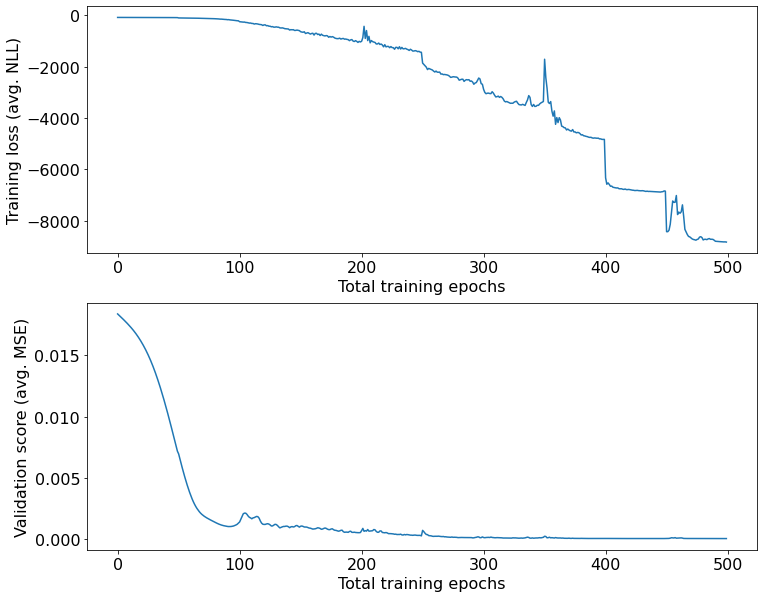

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].plot(train_losses)
ax[0].set_xlabel("Total training epochs")
ax[0].set_ylabel("Training loss (avg. NLL)")
ax[1].plot(val_scores)
ax[1].set_xlabel("Total training epochs")
ax[1].set_ylabel("Validation score (avg. MSE)")
plt.show()